# PUNET

Referenced from https://github.com/SinMDM/SinMDM/blob/main/models/mdm_unet.py

In [1]:
from abc import abstractmethod
import math
import numpy as np
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F


import math

def convert_module_to_f16(l):
    """
    Convert primitive modules to float16.
    """
    if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        l.weight.data = l.weight.data.half()
        if l.bias is not None:
            l.bias.data = l.bias.data.half()


def convert_module_to_f32(l):
    """
    Convert primitive modules to float32, undoing convert_module_to_f16().
    """
    if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        l.weight.data = l.weight.data.float()
        if l.bias is not None:
            l.bias.data = l.bias.data.float()




class SiLU(nn.Module):
    def forward(self, x):
        return x * th.sigmoid(x)


class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def conv_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D convolution module.
    """
    if dims == 1:
        return nn.Conv1d(*args, **kwargs)
    elif dims == 2:
        return nn.Conv2d(*args, **kwargs)
    elif dims == 3:
        return nn.Conv3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def linear(*args, **kwargs):
    """
    Create a linear module.
    """
    return nn.Linear(*args, **kwargs)


def avg_pool_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D average pooling module.
    """
    if dims == 1:
        return nn.AvgPool1d(*args, **kwargs)
    elif dims == 2:
        return nn.AvgPool2d(*args, **kwargs)
    elif dims == 3:
        return nn.AvgPool3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def update_ema(target_params, source_params, rate=0.99):
    """
    Update target parameters to be closer to those of source parameters using
    an exponential moving average.
    :param target_params: the target parameter sequence.
    :param source_params: the source parameter sequence.
    :param rate: the EMA rate (closer to 1 means slower).
    """
    for targ, src in zip(target_params, source_params):
        targ.detach().mul_(rate).add_(src, alpha=1 - rate)


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def scale_module(module, scale):
    """
    Scale the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().mul_(scale)
    return module


def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))

def sum_flat(tensor):
    """
    Take the sum over all non-batch dimensions.
    """
    return tensor.sum(dim=list(range(1, len(tensor.shape))))


def normalization(channels):
    """
    Make a standard normalization layer.
    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)


def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = th.exp(
        -math.log(max_period) * th.arange(start=0, end=half, dtype=th.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = th.cat([th.cos(args), th.sin(args)], dim=-1)
    if dim % 2:
        embedding = th.cat([embedding, th.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


def checkpoint(func, inputs, params, flag):
    """
    Evaluate a function without caching intermediate activations, allowing for
    reduced memory at the expense of extra compute in the backward pass.
    :param func: the function to evaluate.
    :param inputs: the argument sequence to pass to `func`.
    :param params: a sequence of parameters `func` depends on but does not
                   explicitly take as arguments.
    :param flag: if False, disable gradient checkpointing.
    """
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)


class CheckpointFunction(th.autograd.Function):
    @staticmethod
    @th.cuda.amp.custom_fwd
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_length = length
        ctx.save_for_backward(*args)
        with th.no_grad():
            output_tensors = ctx.run_function(*args[:length])
        return output_tensors

    @staticmethod
    @th.cuda.amp.custom_bwd
    def backward(ctx, *output_grads):
        args = list(ctx.saved_tensors)

        # Filter for inputs that require grad. If none, exit early.
        input_indices = [i for (i, x) in enumerate(args) if x.requires_grad]
        if not input_indices:
            return (None, None) + tuple(None for _ in args)

        with th.enable_grad():
            for i in input_indices:
                if i < ctx.input_length:
                    # Not sure why the OAI code does this little
                    # dance. It might not be necessary.
                    args[i] = args[i].detach().requires_grad_()
                    args[i] = args[i].view_as(args[i])
            output_tensors = ctx.run_function(*args[:ctx.input_length])

        if isinstance(output_tensors, th.Tensor):
            output_tensors = [output_tensors]

        # Filter for outputs that require grad. If none, exit early.
        out_and_grads = [(o, g) for (o, g) in zip(output_tensors, output_grads) if o.requires_grad]
        if not out_and_grads:
            return (None, None) + tuple(None for _ in args)

        # Compute gradients on the filtered tensors.
        computed_grads = th.autograd.grad(
            [o for (o, g) in out_and_grads],
            [args[i] for i in input_indices],
            [g for (o, g) in out_and_grads]
        )

        # Reassemble the complete gradient tuple.
        input_grads = [None for _ in args]
        for (i, g) in zip(input_indices, computed_grads):
            input_grads[i] = g
        return (None, None) + tuple(input_grads)

class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None, padding_mode='zeros', padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        if use_conv:
            self.conv = conv_nd(dims, self.channels, self.out_channels, 3, padding=padding, padding_mode=padding_mode)

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.dims == 3:
            x = F.interpolate(
                x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest"
            )
        else:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None, padding_mode='zeros', padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = conv_nd(
                dims, self.channels, self.out_channels, 3, stride=stride, padding=padding, padding_mode=padding_mode
            )
        else:
            assert self.channels == self.out_channels
            self.op = avg_pool_nd(dims, kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        dims=2,
        use_checkpoint=False,
        up=False,
        down=False,
        padding_mode='zeros',
        padding=1
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            conv_nd(dims, channels, self.out_channels, 3, padding=padding, padding_mode=padding_mode),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False, dims, padding_mode=padding_mode, padding=padding)
            self.x_upd = Upsample(channels, False, dims, padding_mode=padding_mode, padding=padding)
        elif down:
            self.h_upd = Downsample(channels, False, dims, padding_mode=padding_mode, padding=padding)
            self.x_upd = Downsample(channels, False, dims, padding_mode=padding_mode, padding=padding)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                conv_nd(dims, self.out_channels, self.out_channels, 3, padding=padding, padding_mode=padding_mode)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = conv_nd(
                dims, channels, self.out_channels, 3, padding=padding, padding_mode=padding_mode
            )
        else:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a timestep embedding.
        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(
            self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )

    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = th.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h


class MDM_UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding.
    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
        padding_mode='zeros',
        padding=1
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        # self.motion_args = motion_args
        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample
        self.sub_sample_mult = np.power(2, len(self.channel_mult))
        self.dims = dims
        self.padding_mode = padding_mode
        self.padding = padding

        # for k, v in motion_args.items():
            # setattr(self, k, v)

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        ch = input_ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=padding, padding_mode=self.padding_mode))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                        padding_mode=padding_mode,
                        padding=padding,
                    )
                ]
                ch = int(mult * model_channels)
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                            padding_mode=padding_mode,
                            padding=padding,
                        )
                        if resblock_updown
                        else Downsample(
                            ch, conv_resample, dims=dims, out_channels=out_ch, padding_mode=padding_mode, padding=padding
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                if level == len(channel_mult) - 1 and i == 0:
                    ich = 0
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=int(model_channels * mult),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                        padding_mode=padding_mode,
                        padding = padding,
                )
                ]
                ch = int(model_channels * mult)
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                            padding_mode=padding_mode,
                            padding=padding,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, dims=dims, out_channels=out_ch, padding_mode=padding_mode, padding=padding)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, input_ch, out_channels, 3, padding=padding, padding_mode=padding_mode)),
        )

        self.clip_dim = 512  # FIXME - hardcoded
        # if 'text' in self.motion_args['cond_mode']:
        #     self.embed_text = nn.Linear(self.clip_dim, 256)  # FIXME - hardcoded
        #     print('EMBED TEXT')

    def convert_to_fp16(self):
        """
        Convert the torso of the model to float16.
        """
        self.input_blocks.apply(convert_module_to_f16)
        self.output_blocks.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """
        Convert the torso of the model to float32.
        """
        self.input_blocks.apply(convert_module_to_f32)
        self.output_blocks.apply(convert_module_to_f32)

    def mask_cond(self, cond):
        bs, d = cond.shape
        # if self.training and self.motion_args['cond_mask_prob'] > 0.:
            # mask = th.bernoulli(th.ones(bs, device=cond.device) * self.motion_args['cond_mask_prob']).view(bs, 1)  # 1-> use null_cond, 0-> use real cond
            # return cond * (1. - mask)
        # else:
        #     return cond
        return cond

    def forward(self, x, timesteps, y=None):
        """
        Apply the model to an input batch.
        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        
        self.n_samples, self.n_joints, self.n_feats, self.n_frames = x.shape
        x = x.reshape(self.n_samples, -1, 1, self.n_frames)

        if self.dims == 1:
            self.resid_frames = ((self.sub_sample_mult - x.shape[2:] % self.sub_sample_mult) % self.sub_sample_mult)[0]
            self.resid_joints = 0
        else:
            self.resid_joints, self.resid_frames = (self.sub_sample_mult - x.shape[2:] % self.sub_sample_mult) % self.sub_sample_mult

        if self.dims == 1:
            # pad frame axis with zeros
            x = th.cat(
                [x, th.zeros((x.shape[0], x.shape[1], self.resid_frames), device=x.device, dtype=x.dtype)],
                dim=-1)  # [bs, 1, J, n_frames] -> [bs, 1, J, padded n_frames]
        else:
            # pad frame axis with zeros
            x = th.cat([x, th.zeros((x.shape[0], x.shape[1], x.shape[2], self.resid_frames), device=x.device, dtype=x.dtype)],
                       dim=-1)  # [bs, 1, J, n_frames] -> [bs, 1, J, padded n_frames]

            # pad joint axis with zeros
            x = th.cat([x, th.zeros((x.shape[0], x.shape[1], self.resid_joints, x.shape[3]), device=x.device, dtype=x.dtype)],
                       dim=-2)  # [bs, 1, J, n_frames] -> [bs, 1, padded J, n_frames]

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.dtype)  # if y is None else th.cat([x, y], dim=1).type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        for level, module in enumerate(self.output_blocks):
            if level == 0:
                h = hs.pop()
            else:
                h = th.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)

        _out = self.out(h)

        if self.resid_frames > 0:
            if self.dims == 1:
                _out = _out[:, :, :-self.resid_frames]
            else:
                _out = _out[:, :, :, :-self.resid_frames]

        if self.resid_joints > 0:
            _out = _out[:, :, :-self.resid_joints, :]

        
        _out = _out.reshape(self.n_samples, self.n_joints, self.n_feats, self.n_frames)
        
        return _out
    

## HYPERPARAMETERS
lr = 0.000001
batch_size= 128
n_joints = 20
n_features = 2
N = 48
n_steps = 1000
num_epochs=300
    
inp = torch.randn(size=(batch_size,20,2,48))
unet = MDM_UNetModel(image_size=2,in_channels=40
    ,model_channels= 32,
    out_channels=40,
    num_res_blocks= 3,
    attention_resolutions= 2)
t = torch.randint(0, 1000, (128,), dtype=torch.long)
out = unet(inp,t)
print(out.shape)



torch.Size([128, 20, 2, 48])


# DIFFUSION MODEL

100%|███████████████████████████████████████| 300/300 [2:29:14<00:00, 29.85s/it]


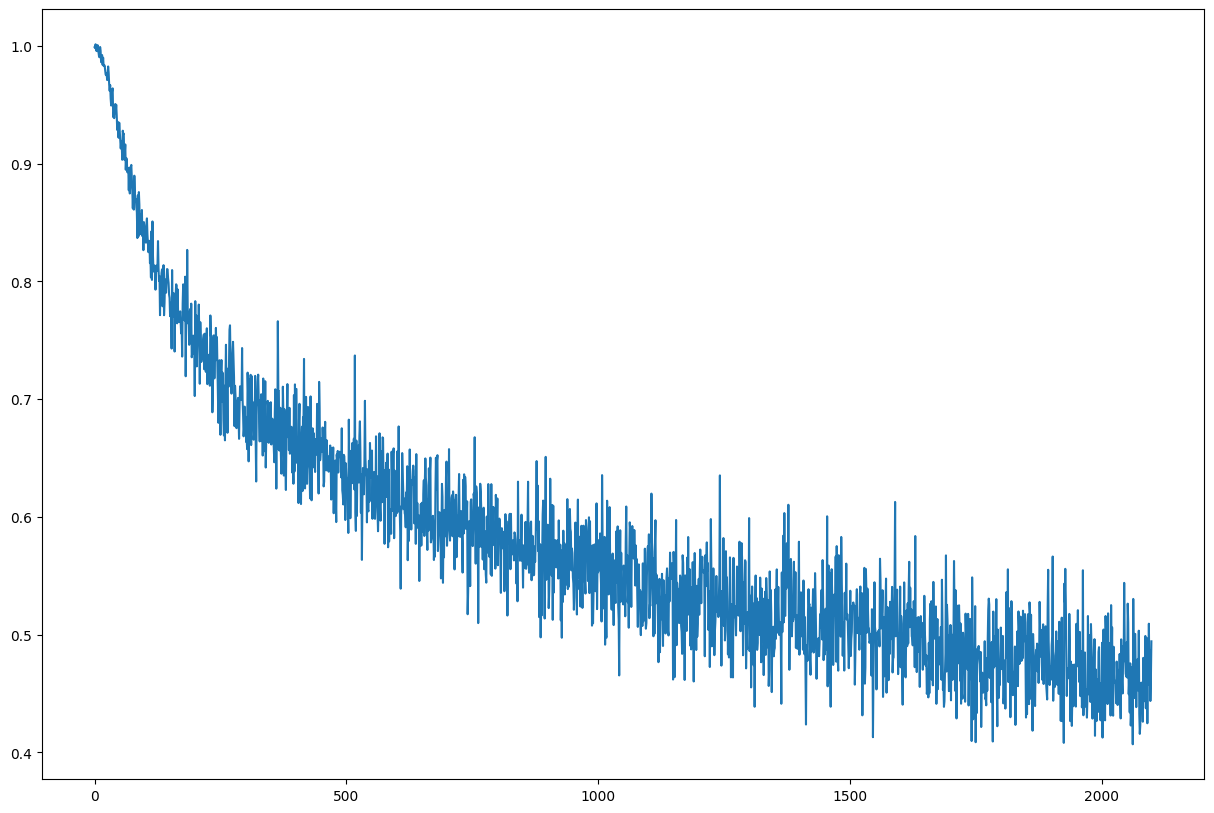

In [2]:


from typing import Optional, Tuple, Union, List
import math
import torch
from torch import nn
import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import MNIST, CIFAR10


import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm, trange
import random
import pandas as pd
import numpy as np
import renderer


data = pd.read_json('data/uptown_funk.json')
cols = data.columns
data = np.array(data)

def make_Frames(data,N,overlap=True):
    results = [] 
    out =[]
    for idx,motion in enumerate(data):
        result = []
        
        for parts in motion:
            result.append(parts)
        out.append(result)
        
        if overlap==True and idx>=N-1:
            results.append(torch.tensor(out[idx-N+1:idx+1]).permute(1,2,0))
            
        elif (idx+1)%N==0:
            results.append(torch.tensor(out[idx-N+1:idx+1]))
    return results





device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_set = make_Frames(data,N)

train_loader = DataLoader(dataset=train_set,batch_size=batch_size, shuffle=True, pin_memory=True)

x = next(iter(train_loader))

def gather(consts: torch.Tensor, t: torch.Tensor):
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)
    
class DDPM:
    def __init__(self, U_net: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.U_net = U_net
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta
        self.sigmat=self.beta*((1-self.alpha_bar/self.alpha)/(1-self.alpha_bar))
        self.lossf = nn.L1Loss()

    def mu_sigma_xt(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - gather(self.alpha_bar, t)
        return mean, var
    
    def qt_q0(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.mu_sigma_xt(x0, t)
        
        return mean + (var ** 0.5) * eps
    
    def xt_1_xt(self, xt: torch.Tensor, t: torch.Tensor):
        eps_theta = self.U_net(xt, t)
        alpha_bar = gather(self.alpha_bar, t)
        alpha = gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = gather(self.sigmat, t)
        eps = torch.randn(xt.shape, device=xt.device)
        
        if t[0]==0:
            return mean
    
        return mean + (var ** .5) * eps
    
    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size,n_features,_,__= x0.shape
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
        if noise is None:
            noise = torch.randn_like(x0)
        xt = self.qt_q0(x0, t, eps=noise)
        eps_theta = self.U_net(xt,t)
        return F.mse_loss(noise, eps_theta)




def train(train_loader,optimizer,diffusion_model,device,num_epochs=5):
    loss_curve = []
    for epoch in trange(num_epochs):
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            loss = diffusion_model.loss(data)
            loss.backward()
            optimizer.step()
            loss_curve.append(loss.cpu().item())
         
            
    fig = plt.figure(figsize=(15,10))
    plt.plot(loss_curve)
    plt.savefig("loss_curve")
    
    return loss_curve
Unet_model = MDM_UNetModel(image_size=48,in_channels=40
    ,model_channels= 32,
    out_channels=40,
    num_res_blocks= 3,
    attention_resolutions= 2).to(device)
Unet_model = nn.DataParallel(Unet_model, list(range(7)))
diffusion_model = DDPM(U_net=Unet_model,
                                  n_steps=n_steps,
                                  device=device)

optimizer = torch.optim.AdamW(Unet_model.parameters(), lr=0.0002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 40, gamma=0.1, last_epoch=- 1, verbose=False)
loss_curve = train(train_loader,optimizer,diffusion_model,device,num_epochs=num_epochs)





# GENERATING NEW MOVES

In [3]:

import renderer





num_samples=5
def get_reshape(cols,x):
    x = x.permute(2,0,1)
    result = {}
    for col in cols:
        result[col]=[]
    for item in x:
        y = (item+180).tolist() 
        for idx, col in enumerate(cols):
            result[col].append(y[idx])
    return result


def generate_samples(diffusion_model,n_samples=num_samples):
    all_x = []
    with torch.no_grad():
        x = torch.randn([n_samples,20,2,N],
                        device=device)

        for t_ in trange(n_steps):
            
            t = n_steps - t_ - 1
            x = diffusion_model.xt_1_xt(x, x.new_full((n_samples,), t, dtype=torch.long))
        return x
        

x = generate_samples(diffusion_model)


for i in range(num_samples):
    y = x[i,:,:,:]
    result = get_reshape(cols,y)
    renderer.render_seq(result,f"./data/epoch{300}_move_{i}.gif")



100%|███████████████████████████████████████| 1000/1000 [01:47<00:00,  9.29it/s]


len landmarks: 48
processed img render len: 48
len landmarks: 48
processed img render len: 48
len landmarks: 48
processed img render len: 48
len landmarks: 48
processed img render len: 48
len landmarks: 48
processed img render len: 48


In [2]:
import pandas as pd

In [4]:
data = pd.read_json('data/uptown_funk.json')
cols = len(data)
cols

895